## **Nocturne** | Performance analysis

The objective is to maximize the probability of the agent taking actions that the expert would take in a given state.  A common loss function is the negative log-likelihood of the expert's actions under the agent's policy, which we briefly derive here. We start with the definition of the likelihood of the expert's actions under the agent's policy:
\begin{align*}
     p(\mathbf{a}^\text{expert} \mid \mathbf{s}, \theta) 
     &\overset{\text{i.i.d}}{=} \prod_{k=1}^K p(\mathbf{a}_k^{\text{expert}} \mid \mathbf{s}_k, \theta) \\
     &= \prod_{k=1}^K \prod_{i=1}^A \pi (a^{\text{expert}_i} \mid \mathbf{s}_k, \theta) \\
\end{align*}
where $\mathbf{s}$ and $\mathbf{a}^\text{expert}$ are sequences of states and expert actions, respectively, $\theta$ are the policy parameters, $A$ are the number of actions and $K$ is the batch size. Since maximizing the likelihood is equivalent to minimizing the negative log-likelihood, we can take the negative logarithm of both sides of the equation:
\begin{align*}
    - \log p(\mathbf{a}^{\text{expert}} \mid \mathbf{s}, \theta) = - \sum_{k=1}^K \sum_{i=1}^A \pi (a^{\text{expert}_i} \mid \mathbf{s}_k, \theta)
\end{align*}
Which gives us the following loss function:
\begin{align*}
    \mathcal{L}(\theta) = - \frac{1}{K} \sum_{k=1}^K \sum_{i=1}^A \log \pi(a^{\text{expert}_{i}} \mid \mathbf{s}_k, \theta)
\end{align*}


## Setup

#### Supported metrics

- **Accuracy** to the expert actions. 
- **Euclidean distance** to the expert positions at a given state and timepoint (the L2 distance between the controlled object's XY
  location and its position in the logged history at the same timestep.) `np.linalg.norm(object_xy - log_xy, axis=-1)`
- **Safe distance through the 3-second rule**
- **Mean absolute error to the expert speed**

In [21]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import torch
import logging
import matplotlib.pyplot as plt

from typing import Callable
from gym import spaces
from stable_baselines3.common.policies import ActorCriticPolicy
from networks.permeq import PermEqNetwork

from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.eval import EvaluatePolicy
from utils.policies import load_policy

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")

### Configurations

In [22]:
# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
model_config = load_config_nb("model_config")

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
EVAL_FILES = ["tfrecord-00001-of-01000_307.json", "tfrecord-00012-of-01000_389.json"]

### Logging

In [23]:
# Logging
logger = logging.getLogger()
logging.basicConfig(format="%(message)s")
logger.setLevel(LOGGING_LEVEL)

### 1. **Behavioral Cloning (BC)**


In [24]:
# Set data path
env_config.data_path = "../data/train/"

# Load trained human reference policy
human_policy = load_policy(
    data_path="../models/il",
    file_name="human_policy_2_scenes_2023_11_22",   
)

# Evaluate policy
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=human_policy,
    eval_files=EVAL_FILES,
    log_to_wandb=False, 
    deterministic=True,
    reg_coef=0.0,
    return_trajectories=True,
)

df_il_res, df_il_trajs = evaluator._get_scores()

INFO:root:Evaluating policy on tfrecord-00001-of-01000_307.json...


INFO:root:Evaluating policy on tfrecord-00012-of-01000_389.json...


In [25]:
df_il_res.round(3)

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations
0,None,tfrecord-00001-of-01000_307.json,3,0.0,0.258,4.814,0.485,0.667,0.333,0.0,0
1,None,tfrecord-00012-of-01000_389.json,4,0.0,0.172,123.747,73.352,0.250,0.500,0.0,0


In [26]:
df_il_trajs.head()

,traffic_scene,timestep,agent_id,policy_pos_x,policy_pos_y,policy_speed,policy_act,expert_pos_x,expert_pos_y,expert_speed,expert_act
0,tfrecord-00001-of-01000_307.json,0,0,384.915955,10800.150391,8.606771,2.0,384.915955,10800.150391,8.606771,17.0
1,tfrecord-00001-of-01000_307.json,1,0,384.099518,10799.929688,8.306770,12.0,384.110046,10799.932617,8.348133,2.0
2,tfrecord-00001-of-01000_307.json,2,0,383.297577,10799.712891,8.306770,17.0,383.299530,10799.714844,8.392628,22.0
3,tfrecord-00001-of-01000_307.json,3,0,382.488403,10799.494141,8.456770,12.0,382.468689,10799.495117,8.594049,12.0
4,tfrecord-00001-of-01000_307.json,4,0,381.671967,10799.273438,8.456770,7.0,381.642853,10799.267578,8.566092,2.0


Scene tfrecord-00001-of-01000_307.json


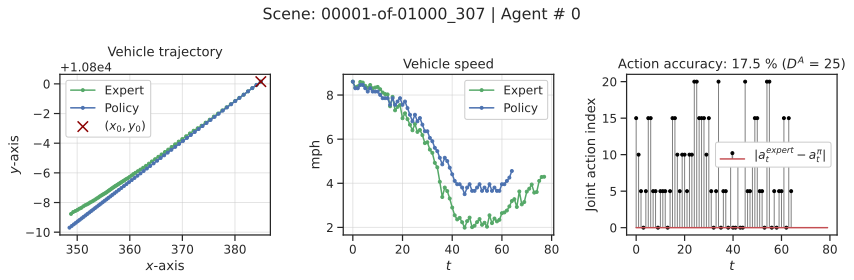

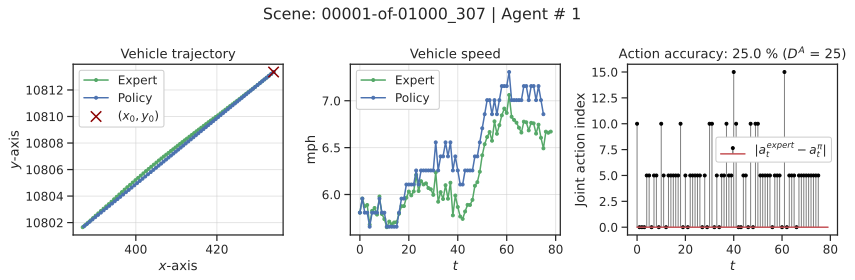

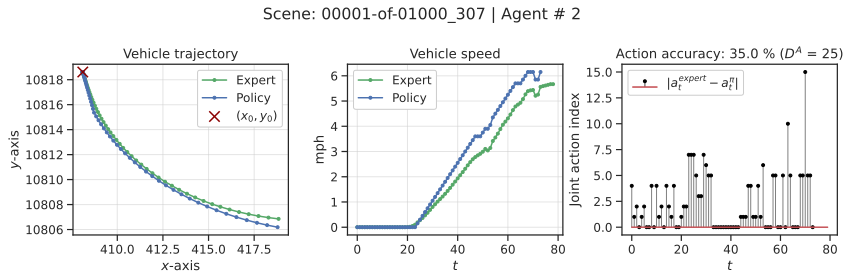

Scene tfrecord-00012-of-01000_389.json


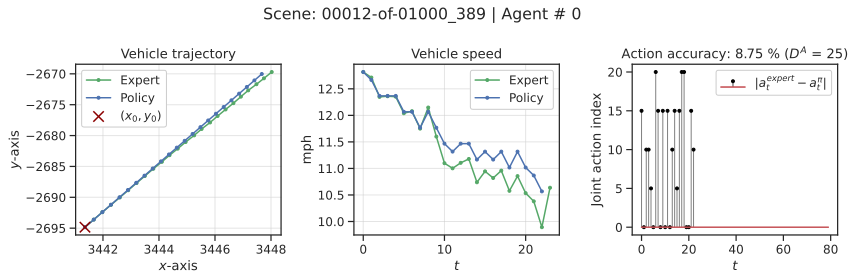

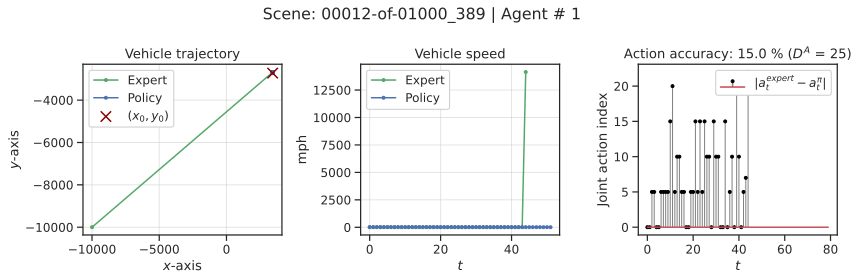

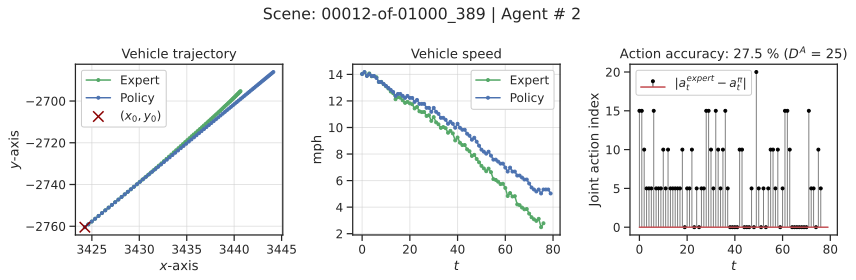

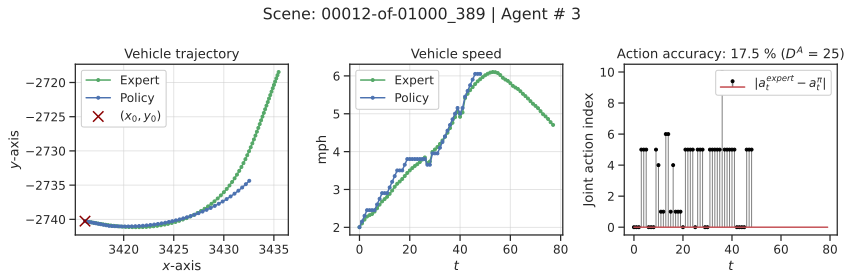

In [27]:
for scene_id in df_il_trajs.traffic_scene.unique():
    df_scene = df_il_trajs[df_il_trajs.traffic_scene == scene_id]
    print(f"Scene {scene_id}")
    for agent_id in df_scene.agent_id.unique():
        agent_df = df_scene[df_scene.agent_id == agent_id]
        plot_agent_trajectory(agent_df, evaluator.env.action_space.n)

### 2. **Reinforcement learning**

In [28]:
class PermEqActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):
        # Disable orthogonal initialization
        kwargs["ortho_init"] = False
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
    def _build_mlp_extractor(self) -> None:
        # Build the network architecture
        self.mlp_extractor = PermEqNetwork(
            self.features_dim
            # feature_dim=checkpoint['model']['feat_dim'],
            # arch_ego_state=checkpoint['model']['arch_ego_state'],
            # arch_obs=checkpoint['model']['arch_obs'],
        )

In [29]:
RL_POLICY_PATH = "../models/rl"
RL_POLICY_NAME = "nocturne-hr-ppo-11_28_19_34" # goal rate 100%

# Load trained model from artifact dir
checkpoint = torch.load(f"{RL_POLICY_PATH}/{RL_POLICY_NAME}.pt")

policy = PermEqActorCriticPolicy(**checkpoint['data'])
policy.load_state_dict(checkpoint['state_dict'])
policy.eval();

In [30]:
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=policy,
    eval_files=EVAL_FILES,
    log_to_wandb=False, 
    deterministic=True,
    reg_coef=0.0,
    return_trajectories=True,
)

df_rl_res, df_rl_trajs = evaluator._get_scores()

INFO:root:Evaluating policy on tfrecord-00001-of-01000_307.json...
INFO:root:Evaluating policy on tfrecord-00012-of-01000_389.json...


In [31]:
df_rl_res

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations
0,None,tfrecord-00001-of-01000_307.json,3,0.0,0.033333,9.922804,3.441831,1.0,0.0,0.0,0
1,None,tfrecord-00012-of-01000_389.json,4,0.0,0.031250,9.003822,1.350428,1.0,0.0,0.0,0


Scene tfrecord-00001-of-01000_307.json


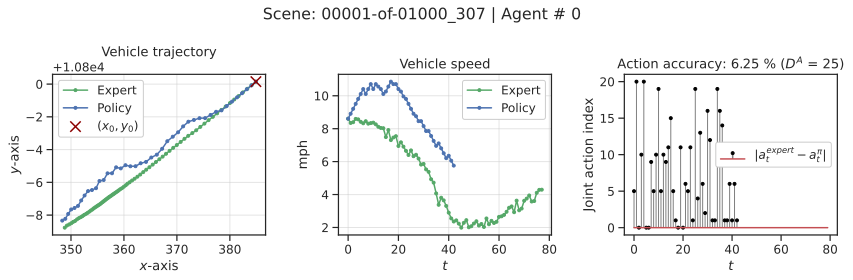

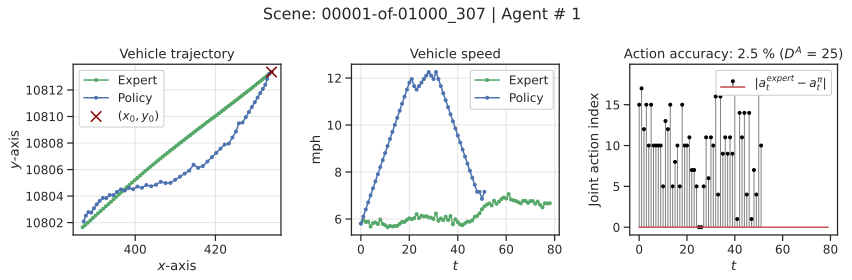

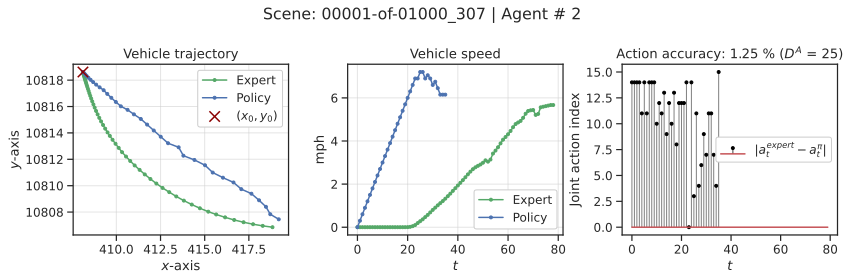

Scene tfrecord-00012-of-01000_389.json


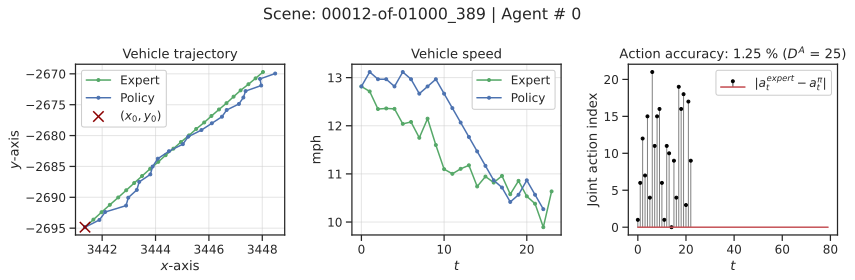

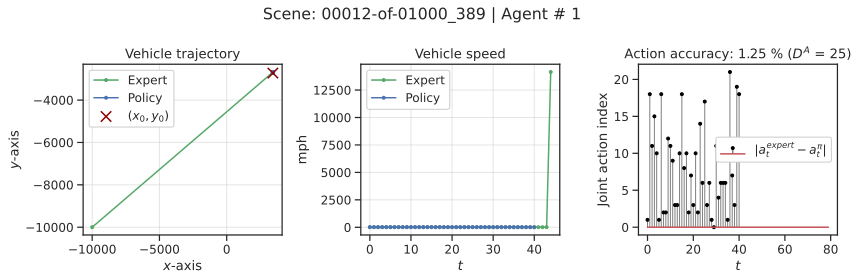

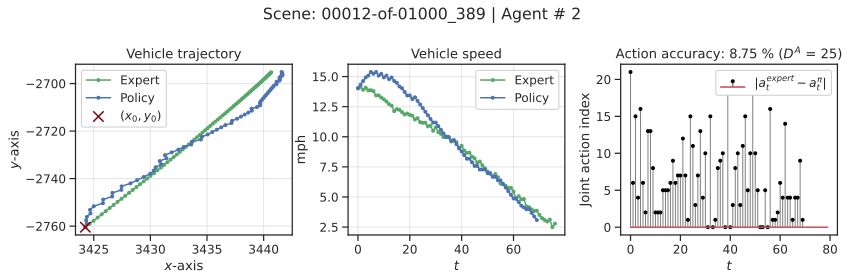

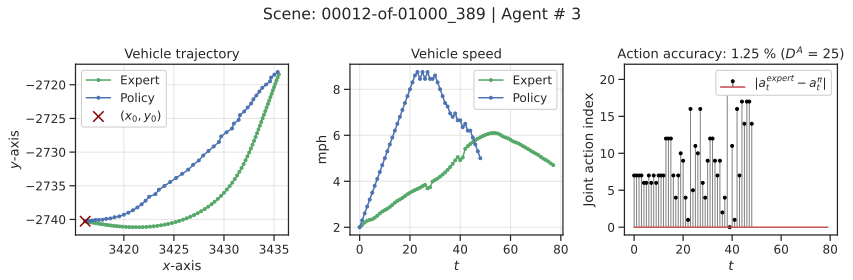

In [32]:
for scene_id in df_rl_trajs.traffic_scene.unique():
    df_scene = df_rl_trajs[df_rl_trajs.traffic_scene == scene_id]
    print(f"Scene {scene_id}")
    for agent_id in df_scene.agent_id.unique():
        agent_df = df_scene[df_scene.agent_id == agent_id]
        plot_agent_trajectory(agent_df, evaluator.env.action_space.n)

### 3. **Human-regularized RL**

In [37]:
model_names = ["nocturne-hr-ppo-11_28_19_16_0.025", "nocturne-hr-ppo-11_28_20_10_0.050", "nocturne-hr-ppo-11_28_21_01_0.075"]
RL_POLICY_PATH = "../models/hr_rl"

In [38]:
RL_POLICY_NAME = model_names[0]
# Load trained model from artifact dir
checkpoint = torch.load(f"{RL_POLICY_PATH}/{RL_POLICY_NAME}.pt")
policy = PermEqActorCriticPolicy(**checkpoint['data'])
policy.load_state_dict(checkpoint['state_dict'])
policy.eval();

evaluator_reg_025 = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=policy,
    eval_files=EVAL_FILES,
    log_to_wandb=False, 
    deterministic=True,
    reg_coef=0.025,
    return_trajectories=True,
)

df_hr_rl_res_025, df_hr_rl_trajs_025 = evaluator._get_scores()

RL_POLICY_NAME = model_names[1]
# Load trained model from artifact dir
checkpoint = torch.load(f"{RL_POLICY_PATH}/{RL_POLICY_NAME}.pt")
policy = PermEqActorCriticPolicy(**checkpoint['data'])
policy.load_state_dict(checkpoint['state_dict'])
policy.eval();

evaluator_reg_050 = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=policy,
    eval_files=EVAL_FILES,
    log_to_wandb=False, 
    deterministic=True,
    reg_coef=0.05,
    return_trajectories=True,
)

df_hr_rl_res_050, df_hr_rl_trajs_050 = evaluator._get_scores()

INFO:root:Evaluating policy on tfrecord-00001-of-01000_307.json...


INFO:root:Evaluating policy on tfrecord-00012-of-01000_389.json...
INFO:root:Evaluating policy on tfrecord-00001-of-01000_307.json...
INFO:root:Evaluating policy on tfrecord-00012-of-01000_389.json...


In [39]:
df_hr_rl_res = pd.concat([df_hr_rl_res_025, df_hr_rl_res_050])  

In [40]:
df_hr_rl_res

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations
0,None,tfrecord-00001-of-01000_307.json,3,0.0,0.033333,9.922804,3.441831,1.0,0.0,0.0,0
1,None,tfrecord-00012-of-01000_389.json,4,0.0,0.031250,9.003822,1.350428,1.0,0.0,0.0,0
0,None,tfrecord-00001-of-01000_307.json,3,0.0,0.033333,9.922804,3.441831,1.0,0.0,0.0,0
1,None,tfrecord-00012-of-01000_389.json,4,0.0,0.031250,9.003822,1.350428,1.0,0.0,0.0,0


### 4. **Summary figures**

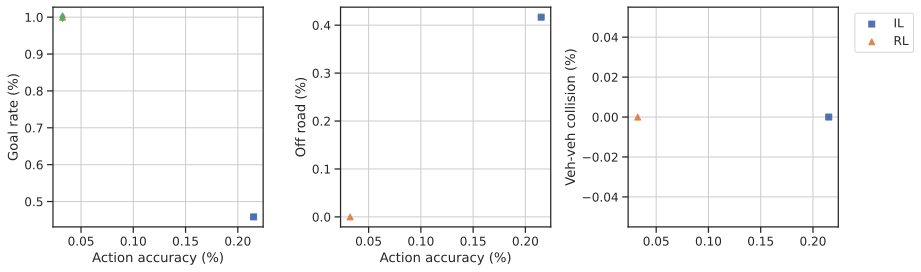

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
axes[0].scatter(df_il_res['act_acc'].mean(), df_il_res['goal_rate'].mean(), marker='s', label="IL")
# RL
axes[0].scatter(df_rl_res['act_acc'].mean(), df_rl_res['goal_rate'].mean(), marker='^', label="RL")
# HR-RL
axes[0].scatter(df_hr_rl_res_025['act_acc'].mean(), df_hr_rl_res_025['goal_rate'].mean(), marker='d', label="HR-RL 0.025")

# Accuracy to off road
# IL
axes[1].scatter(df_il_res['act_acc'].mean(), df_il_res['veh_edge_cr'].mean(), marker='s', label="IL")

# RL
axes[1].scatter(df_rl_res['act_acc'].mean(), df_rl_res['veh_edge_cr'].mean(), marker='^', label="RL")

# Accuracy to collision rate
# IL
axes[2].scatter(df_il_res['act_acc'].mean(), df_il_res['veh_veh_cr'].mean(), marker='s', label="IL")

# RL
axes[2].scatter(df_rl_res['act_acc'].mean(), df_rl_res['veh_veh_cr'].mean(), marker='^', label="RL")


axes[0].grid(True) 
axes[1].grid(True) 
axes[2].grid(True) 
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].set_xlabel('Action accuracy (%)')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_xlabel('Action accuracy (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')
plt.tight_layout()

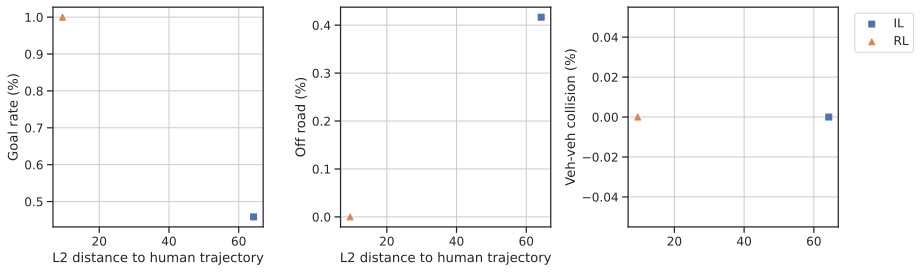

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
axes[0].scatter(df_il_res['pos_rmse'].mean(), df_il_res['goal_rate'].mean(), marker='s', label="IL")
# RL
axes[0].scatter(df_rl_res['pos_rmse'].mean(), df_rl_res['goal_rate'].mean(), marker='^', label="RL")
# HR-RL
axes[0].scatter(df_rl_res['pos_rmse'].mean(), df_rl_res['goal_rate'].mean(), marker='^', label="RL")

# Accuracy to off road
# IL
axes[1].scatter(df_il_res['pos_rmse'].mean(), df_il_res['veh_edge_cr'].mean(), marker='s', label="IL")

# RL
axes[1].scatter(df_rl_res['pos_rmse'].mean(), df_rl_res['veh_edge_cr'].mean(), marker='^', label="RL")

# Accuracy to collision rate
# IL
axes[2].scatter(df_il_res['pos_rmse'].mean(), df_il_res['veh_veh_cr'].mean(), marker='s', label="IL")

# RL
axes[2].scatter(df_rl_res['pos_rmse'].mean(), df_rl_res['veh_veh_cr'].mean(), marker='^', label="RL")


axes[0].grid(True) 
axes[1].grid(True) 
axes[2].grid(True) 
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].set_xlabel('L2 distance to human trajectory')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_xlabel('L2 distance to human trajectory')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')
plt.tight_layout()